<div class="alert alert-block alert-info">
<h1>Clustering : <code>6-clustering.ipynb</code></h1>
</div>

---

### The purpose of this notebook is to use different methods to cluster samples or features.

Many different clustering methods exist and it is complex to know which one is the most relevant to apply to a specific dataset. A table in scikit-learn documentation can help ([link](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods))

---
# Table of contents
- [0 - Import modules](#0---Import-modules)
- [0 - Import useful functions](#0---Import-useful-functions)
- [0 - Import peak table](#0---Import-peak-table)
  - [a - Keep only metadata in the following dataframe](#a---Keep-only-metadata-in-the-following-dataframe)
  - [b - Keep only intensities in the following dataframe](#b---Keep-only-intensities-in-the-following-dataframe)
  - [c - Set target feature](#c---Set-target-feature)
  - [d - Create dataframe to later save the predicted clusters for each clustering method](#d---Create-dataframe-to-later-save-the-predicted-clusters-for-each-clustering-method)
- [1 - K-Means](#1---K-Means)
  - [a - Try different number of clusters](#a---Try-different-number-of-clusters)
  - [b - Plot the inertia vs. the number of clusters](#b---Plot-the-inertia-vs.-the-number-of-clusters)
- [2 - Affinity propagation](#2---Affinity-propagation)
- [3 - Mean shift](#3---Mean-shift)
- [4 - Hierarchical clustering](#4---Hierarchical-clustering)
- [5 - DBSCAN](#5---DBSCAN)
- [6 - OPTICS](#6---OPTICS)
---

### References 

- https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods
- https://pubmed.ncbi.nlm.nih.gov/30421236/
- https://pubs.acs.org/doi/10.1021/acs.analchem.9b03084
- https://medium.com/@dilip.voleti/dbscan-algorithm-for-fraud-detection-outlier-detection-in-a-data-set-60a10ad06ea8
- https://aneesha.medium.com/using-affinity-propagation-to-find-the-number-of-clusters-in-a-dataset-52f5dd3b0760
- https://stats.stackexchange.com/questions/270631/why-are-most-of-my-points-classified-as-noise-using-dbscan
- https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

# 0 - Import modules

In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
# Setting working directory
import re
pwd = ! pwd
pwd = re.sub('notebooks/', '', pwd[0])
pwd = '/'.join(pwd.split('/')[:-1]) + '/'
print(f'Working directory : {pwd}')

# Print Python version
python_version = ! python --version
print(f'Python version : {python_version[0]}')

Working directory : /home/jovyan/work/
Python version : Python 3.10.4


In [3]:
# Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook", font_scale=1.2, rc={"axes.titlesize": 15}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 12, 8

sns.set_theme(style="darkgrid")

# 0 - Import useful functions

In [4]:
# In the bin folder, python scripts containing useful functions can be found.
# Functions for data exploration are located in file clustering_functions.py

import sys
sys.path.append(pwd + 'bin/')

from clustering_functions import *

# 0 - Import peak table

#### We import peak table reduced in the previous notebook

In [5]:
path_peakTable = pwd + 'data/synthetic_dataset/reduced_peak_tables/'
reduced_peakTables = [file for file in os.listdir(path_peakTable) if file.endswith('.csv')]
print(f'Available reduced peak tables :\n')
reduced_peakTables

Available reduced peak tables :



['intensities-PCA_10components.csv',
 'intensities-PCA_70percent.csv',
 'peakTable-PCA_95percent-UMAP_2components.csv',
 'peakTable-PCA_95percent-UMAP_3components.csv',
 'peakTable-PCA_95percent-tSNE_2components.csv',
 'peakTable-PCA_95percent-tSNE_3components.csv',
 'peakTable-PCA_95percent.csv',
 'peakTable-kBest_20.csv',
 'peakTable-kBest_211.csv',
 'peakTable-kBest_59.csv']

We choose to import peak table reduced to 2 components with t-SNE method to visualise results 

In [6]:
chosen_peakTable = 'peakTable-PCA_95percent-tSNE_2components.csv'
peakTable = pd.read_csv(path_peakTable + chosen_peakTable, sep=',', decimal='.', na_values='NA')
peakTable

,SampleID,Disease,tSNE1,tSNE2
0,CRR_001,CRR,17.943443,-31.575830
1,CRR_002,CRR,17.558340,-30.981756
2,CRR_003,CRR,36.855774,-18.470953
3,CRR_004,CRR,36.947426,-15.343476
4,CRR_005,CRR,49.960890,-22.557018
...,...,...,...,...
595,HCC_296,HCC,-21.229502,17.677505
596,HCC_297,HCC,-42.531210,-34.786710
597,HCC_298,HCC,-7.197294,-20.259794
598,HCC_299,HCC,-42.679344,-23.189226


Here we stock in variable <code>col_prefix</code> the prefix of the column names, depending on which peak table have been imported above.

In [7]:
col_prefix = re.sub('peakTable-', '', re.sub('.csv', '', chosen_peakTable)).split('-')[-1].split('_')[0]
if col_prefix == 'kBest' : col_prefix = 'variable_'
if col_prefix == 'PCA' : col_prefix = 'PC'
col_prefix

'tSNE'

## a - Keep only metadata in the following dataframe

In [8]:
metadata = peakTable.iloc[:, [col_prefix not in col for col in peakTable.columns]]
metadata

,SampleID,Disease
0,CRR_001,CRR
1,CRR_002,CRR
2,CRR_003,CRR
3,CRR_004,CRR
4,CRR_005,CRR
...,...,...
595,HCC_296,HCC
596,HCC_297,HCC
597,HCC_298,HCC
598,HCC_299,HCC


## b - Keep only intensities in the following dataframe

In [9]:
intensities = peakTable.iloc[:, [col_prefix in col for col in peakTable.columns]]
intensities

,tSNE1,tSNE2
0,17.943443,-31.575830
1,17.558340,-30.981756
2,36.855774,-18.470953
3,36.947426,-15.343476
4,49.960890,-22.557018
...,...,...
595,-21.229502,17.677505
596,-42.531210,-34.786710
597,-7.197294,-20.259794
598,-42.679344,-23.189226


## c - Set target feature

### Our target here is <code>Disease</code> column in metadata, let's create a variable <code>target</code>

In [10]:
target = metadata['Disease']
target

0      CRR
1      CRR
2      CRR
3      CRR
4      CRR
      ... 
595    HCC
596    HCC
597    HCC
598    HCC
599    HCC
Name: Disease, Length: 600, dtype: object

## d - Create dataframe to later save the predicted clusters for each clustering method

In [11]:
clustering_labels_samples = pd.DataFrame()

# 1 - K-Means

#### The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia.

#### This algorithm requires the number of clusters to be specified.

C.f. [doc scikit learn](https://scikit-learn.org/stable/modules/clustering.html#k-means)

Function <code>perform_kmeans</code> is designed to perform k-means clustering on the dataframe passed as argument. We specify the number of clusters in <code>n_clusters</code>. If inputed dataframe has two variables, we plot the results as shown below. We can also pass argument <code>target</code> to display points with color depending on their target value.

## a - Try different number of clusters

### With 2 clusters (maybe HCC vs. CRR will be separated)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


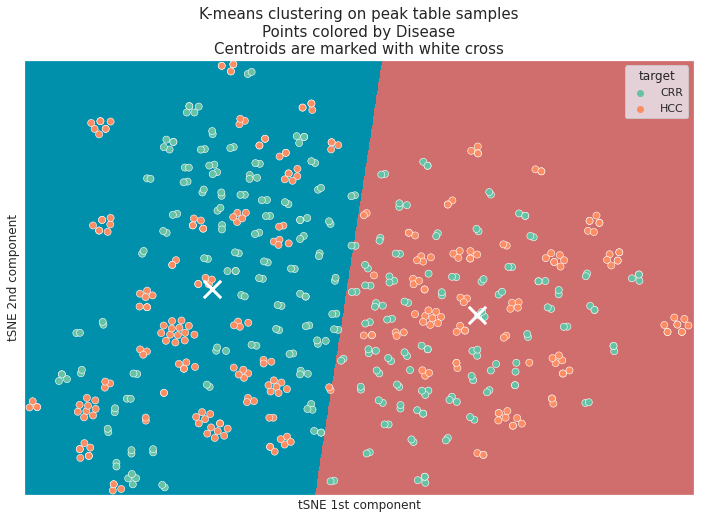

Inertia of k-means model : 437250.17
Adjusted rand index of k-means model : 0.003


In [12]:
n_clusters = 2
kmeans = perform_kmeans(intensities, n_clusters=n_clusters, target=target, col_prefix=col_prefix)

#### We can observe that the two groups don't separate at all. The adjusted rand index is close to 0 which means the predicted labels are bad prediction of the true labels (target passed as argument)
 
#### One major reason is that keeping only the 2 principal components with the t-SNE reduction only keeps a really small amount of the initial variance.

#### Dataframes with more than 2 dimensions cannot be plotted like above but probably would give better results.

In [13]:
# Save results
clustering_labels_samples[f'kmeans_{n_clusters}'] = kmeans.labels_
clustering_labels_samples

,kmeans_2
0,1
1,1
2,1
3,1
4,1
...,...
595,0
596,0
597,0
598,0


### With 3 clusters

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


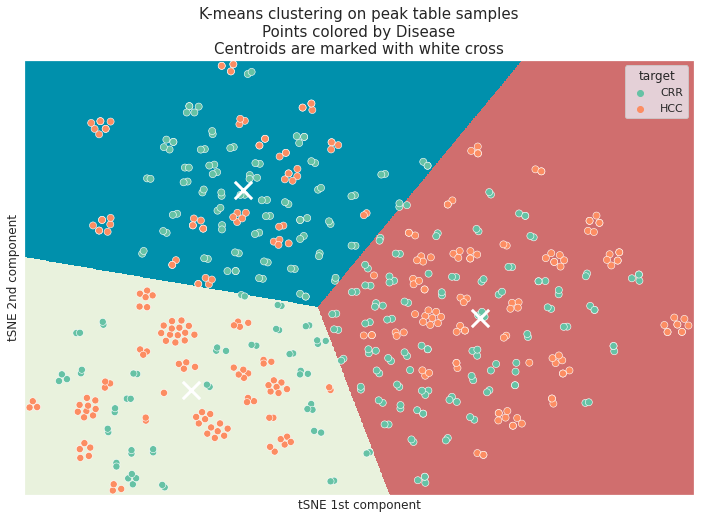

Inertia of k-means model : 252989.25


In [14]:
n_clusters = 3
kmeans = perform_kmeans(intensities, n_clusters=n_clusters, target=target, col_prefix=col_prefix)

#### Same here, we can observe that the three groups don't separate at all. The adjusted rand index is close to 0 which means the predicted labels are bad prediction of the true labels

In [15]:
# Save results
clustering_labels_samples[f'kmeans_{n_clusters}'] = kmeans.labels_
clustering_labels_samples

,kmeans_2,kmeans_3
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
595,0,0
596,0,1
597,0,1
598,0,1


### With a higher number of clusters

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


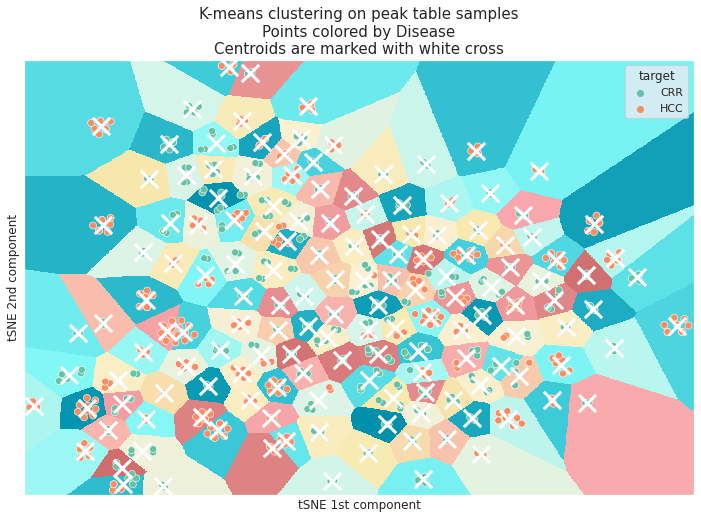

Inertia of k-means model : 1606.65


In [16]:
n_clusters = 150
kmeans = perform_kmeans(intensities, n_clusters=n_clusters, target=target, col_prefix=col_prefix)

#### We could observe before that some samples are really close to each other on the plot. Here we hugely increase the number of clusters.

In [17]:
# Save results
clustering_labels_samples[f'kmeans_{n_clusters}'] = kmeans.labels_
clustering_labels_samples

,kmeans_2,kmeans_3,kmeans_150
0,1,2,111
1,1,2,111
2,1,2,116
3,1,2,116
4,1,2,127
...,...,...,...
595,0,0,76
596,0,1,49
597,0,1,17
598,0,1,2


## b - Plot the inertia vs. the number of clusters

#### Here we plot the value of inertia (sum of squared distances of samples to their closest cluster center) vs. number of clusters

Function <code>plot_inertia</code> plots the inertia of k-means models, depending on the number of clusters. By default, all values of number of clusters are tested from 1 to the number of rows in the inputed dataframe. We can set the parameter <code>max_clusters</code> to test up to a specific value.

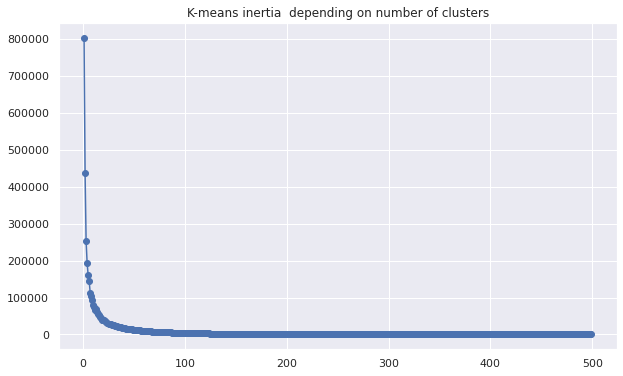

In [27]:
plot_inertia(intensities, max_clusters=500)

We can observe that the value of inertia quickly decreases and then tends towards zero (if <code>n_clusters</code> = <code>n_samples</code>, inertia = 0)

By setting parameter <code>log</code> to True, we can plot the log values of inertia, to better observe the moment inertia tends towards 0.

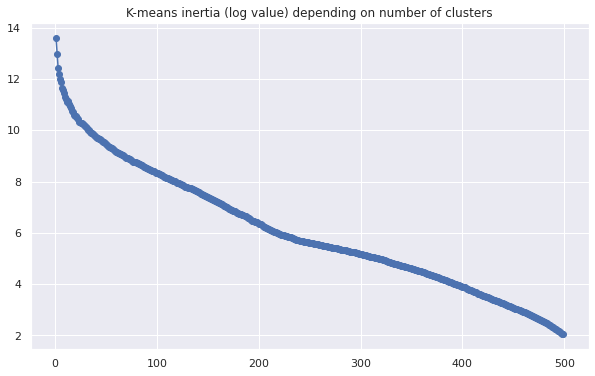

In [28]:
plot_inertia(intensities, max_clusters=500, log=True)

### Conclusion

#### K-means method requires to specify the number of clusters. It can be difficult to know *a priori* the most relevant number of clusters. Thus, it is better to have biological knowledge on the dataset for this method.

# 2 - Affinity propagation

#### Affinity propagation method creates clusters iteratively, by linking samples as pairs, until convergence is reached.

#### This method chooses the number of clusters based on the data provided, no need to specify it before.

C.f. [doc scikit learn](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)

Function <code>perform_affinity_propagation</code> is designed to perform affinity propagation clustering on the dataframe passed as argument. We can also specify a <code>target</code> parameter to compute some metrics between the labels estimated by the model and the true labels for each sample. All these metrics have a value between 0 and 1, a value close to 1 indicates that predicted and true labels are similar.

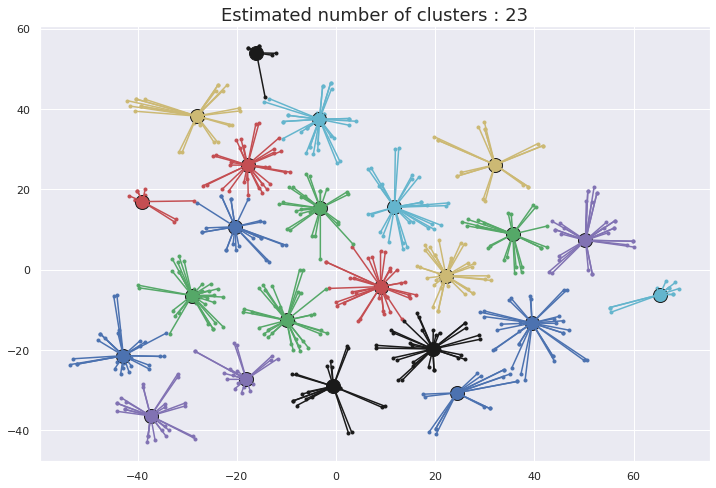

In [19]:
af = perform_affinity_propagation(intensities)

Estimated number of clusters: 23
Homogeneity: 0.141
Completeness: 0.032
V-measure: 0.052
Adjusted Rand Index: 0.014
Adjusted Mutual Information: 0.042
Silhouette Coefficient: 0.520


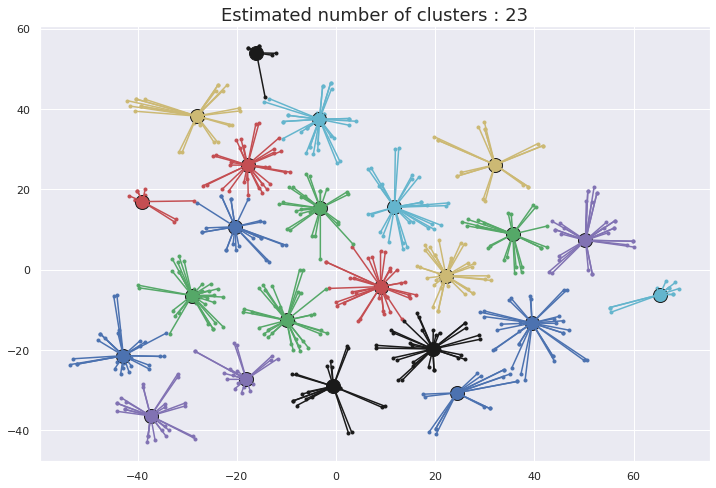

In [20]:
af = perform_affinity_propagation(intensities, target=target)

In [21]:
# Save results
clustering_labels_samples[f'af_{len(af.cluster_centers_indices_)}'] = af.labels_
clustering_labels_samples

,kmeans_2,kmeans_3,kmeans_150,af_23
0,1,2,111,0
1,1,2,111,0
2,1,2,116,14
3,1,2,116,14
4,1,2,127,14
...,...,...,...,...
595,0,0,76,7
596,0,1,49,11
597,0,1,17,15
598,0,1,2,21


# 3 - Mean shift

#### *"MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region."*

#### *"The algorithm automatically sets the number of clusters."*

C.f. [doc scikit learn](https://scikit-learn.org/stable/modules/clustering.html#mean-shift)

Function <code>perform_mean_shift</code> is designed to perform mean shift clustering on the dataframe passed as argument.

Estimated number of clusters : 2


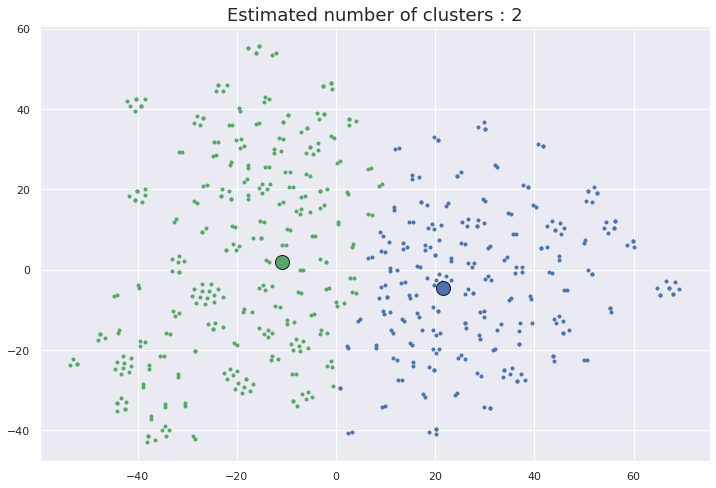

In [22]:
ms = perform_mean_shift(intensities)

In [23]:
# Save results
clustering_labels_samples[f'ms_{len(ms.cluster_centers_)}'] = ms.labels_
clustering_labels_samples

,kmeans_2,kmeans_3,kmeans_150,af_23,ms_2
0,1,2,111,0,0
1,1,2,111,0,0
2,1,2,116,14,0
3,1,2,116,14,0
4,1,2,127,14,0
...,...,...,...,...,...
595,0,0,76,7,1
596,0,1,49,11,1
597,0,1,17,15,1
598,0,1,2,21,1


# 4 - Hierarchical clustering

With hierarchical clustering, each observation starts in its own cluster, and clusters are successively merged together. The hierarchy of clusters is represented as a tree/dendrogram.

C.f. [doc scikit learn](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

First, we use function <code>plot_dendrogram</code> to plot the dendrogram from the dataframe passed as argument. We can also pass the argument <code>hline</code> to plot an horizontal line on the figure at the corresponding value on y-axis. The number of intersections between the horzontal line and the dendrogramm can be passed in the function <code>perform_hierarchical_clustering</code> below. The higher the value of <code>hline</code> we choose, the lower the number of clusters will be.

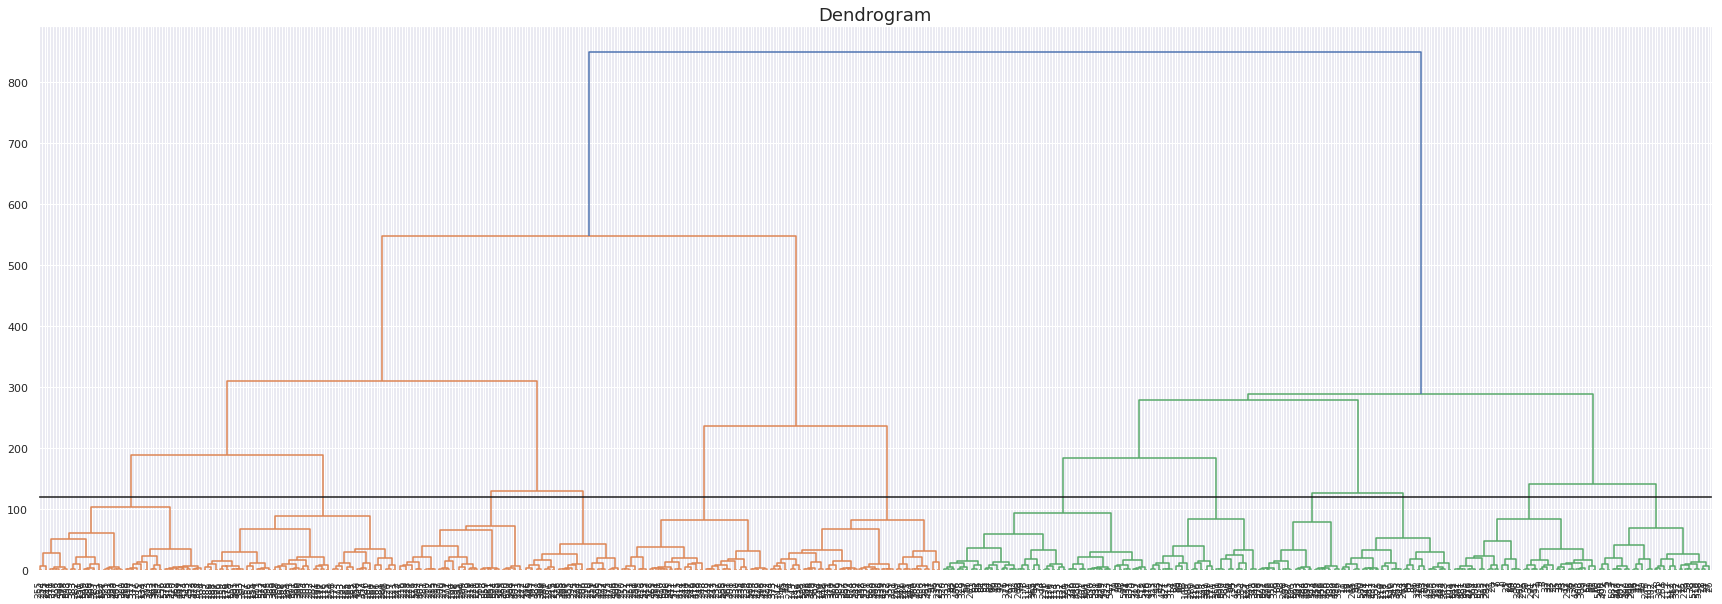

In [24]:
plot_dendrogram(intensities, hline=120)

Then, function <code>perform_hierarchical_clustering</code> plots samples of dataframe passed as argument as points, colouring based on their cluster.

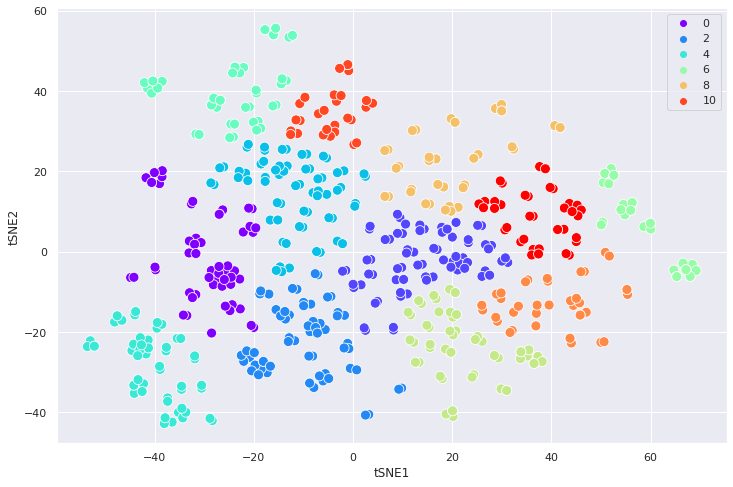

In [25]:
n_clusters = 12
hc = perform_hierarchical_clustering(intensities, n_clusters=n_clusters)

In [26]:
# Save results
clustering_labels_samples[f'hc_{hc.n_clusters_}'] = hc.labels_
clustering_labels_samples

,kmeans_2,kmeans_3,kmeans_150,af_23,ms_2,hc_12
0,1,2,111,0,0,7
1,1,2,111,0,0,7
2,1,2,116,14,0,9
3,1,2,116,14,0,9
4,1,2,127,14,0,9
...,...,...,...,...,...,...
595,0,0,76,7,1,3
596,0,1,49,11,1,4
597,0,1,17,15,1,2
598,0,1,2,21,1,4


# 5 - DBSCAN

#### *"The DBSCAN algorithm views clusters as areas of high density separated by areas of low density"*

C.f. [doc scikit learn](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

In [29]:
db = perform_DBSCAN(intensities, target=target)
db

'DBSCAN detects all points as noise/outliers'

#### Here DBSCAN detects all points as noise/outliers so we have to tune a bit the hyperparameters.

C.f. [Medium topic](https://medium.com/@dilip.voleti/dbscan-algorithm-for-fraud-detection-outlier-detection-in-a-data-set-60a10ad06ea8) :

_DBSCAN requires only two parameters: epsilon and minPoints. Epsilon is the radius of the circle to be created around each data point to check the density and minPoints is the minimum number of data points required inside that circle for that data point to be classified as a Core point._

Function <code>get_eps_optimal_value</code> gives the optimal value of espilon to pass to the DBSCAN clustering method.

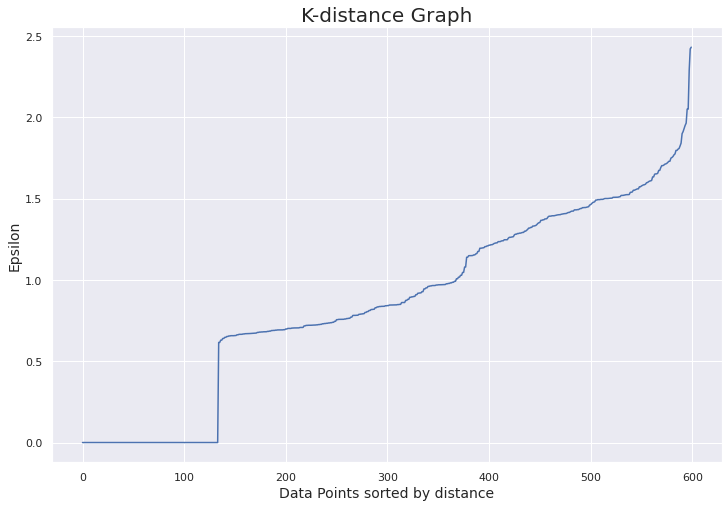

Optimal value to pass DBSCAN model is : 2.5


In [31]:
opt_eps = get_eps_optimal_value(intensities)

*"The optimum value of epsilon is at the point of maximum curvature in the K-Distance Graph. [...] The value of minPoints also depends on domain knowledge"*


Function <code>perform_DBSCAN</code> performs DBSCAN clustering on the dataframe passed as argument. We also pass the optimal value of <code>eps</code> we got from <code>get_eps_optimal_value</code> function and <code>min_samples</code>.

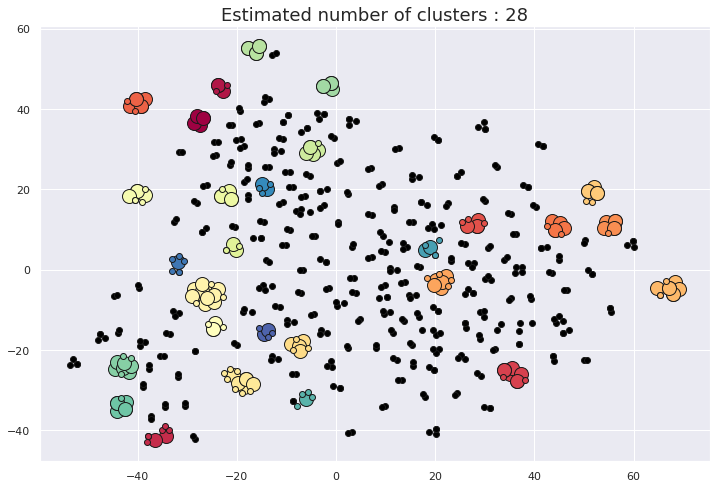

DBSCAN(eps=2.5)

In [34]:
db = perform_DBSCAN(intensities, eps=opt_eps, min_samples=5)
db

In [30]:
# Save results
clustering_labels_samples[f'db_{len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)}'] = db.labels_
clustering_labels_samples

,kmeans_2,kmeans_3,kmeans_150,af_23,ms_2,hc_12,db_28
0,1,2,111,0,0,7,-1
1,1,2,111,0,0,7,-1
2,1,2,116,14,0,9,-1
3,1,2,116,14,0,9,-1
4,1,2,127,14,0,9,-1
...,...,...,...,...,...,...,...
595,0,0,76,7,1,3,16
596,0,1,49,11,1,4,22
597,0,1,17,15,1,2,11
598,0,1,2,21,1,4,21


# 6 - OPTICS

#### *"The OPTICS algorithm shares many similarities with the DBSCAN algorithm, and can be considered a generalization of DBSCAN that relaxes the eps requirement from a single value to a value range. The key difference between DBSCAN and OPTICS is that the OPTICS algorithm builds a reachability graph, which assigns each sample both a reachability_ distance, and a spot within the cluster ordering_ attribute; these two attributes are assigned when the model is fitted, and are used to determine cluster membership."*

C.f. [doc scikit learn](https://scikit-learn.org/stable/modules/clustering.html#optics)

Function <code>perform_OPTICS</code> performs OPTICS clustering on dataframe passed as argument. By default, the <code>list_eps</code> argument has 3 values $\{0.5, 1, 2\}$. First, we can perform clustering with the default values and then re-perform it with adjusted values.

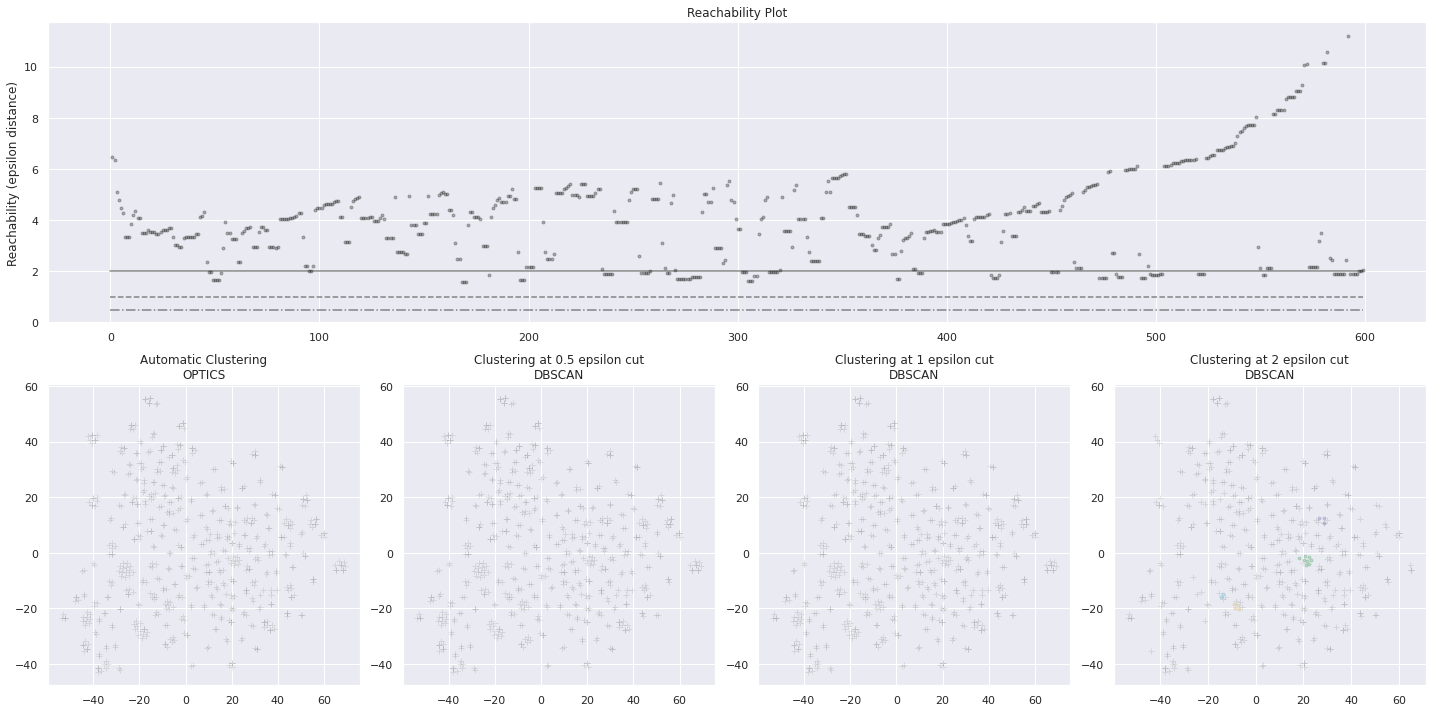

In [36]:
optics = perform_OPTICS(intensities)

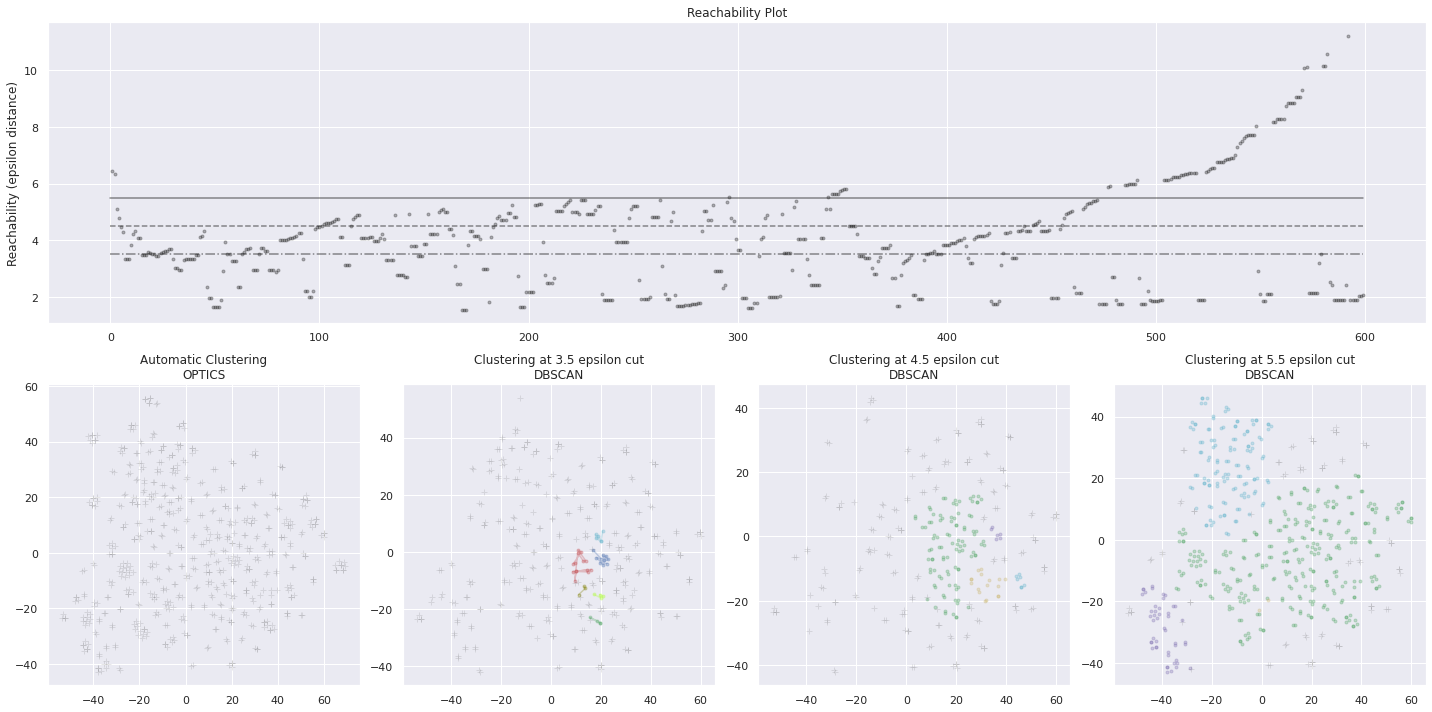

In [40]:
optics = perform_OPTICS(intensities, list_eps=[3.5, 4.5, 5.5])